# Introdução à ML: Previsão de Risco de Crédito

Fonte: [Universidade dos Dados](https://www.youtube.com/watch?v=GPdQnHAiGWo)

## Tipos de Aprendizado

1. Supervisionado: dados rotulados (pagou ou não o empréstimo? risco de crédito!)

2. Não-Supervisionado: dados não-rotulados (como agrupar ou *clusterizar* clientes semelhantes?)

## Trade-off Viés-Variância

Quanto mais complexo o modelo, maior a variância de seus resultados, mas isso causa overfitting nos dados de teste.
Contudo, quanto mais simples for o modelo, maior o erro de viés dele.

Ponto ótimo: algum lugar no meio!

<img src="./Imagens/bias_variance.png" alt="Erro de Viés e Variância" width="400"/>

## Setup e Bibliotecas

In [82]:
## Manipulação de Dados
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

## Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
import sweetviz as sv

## Modelagem ML
# Encodings
import category_encoders as ce
from sklearn.impute import SimpleImputer

# Métricas de avaliação
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Outros
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, truncnorm, randint

## Outros
import os
import sys

In [31]:
## Função própria (github.com/vnery5/Econometria)
# Criando caminho e adicionando-o ao caminho do Python
sCaminhoEconometria = "/Users/vinicius/Meu Drive/UnB/Econometria/"
sys.path.append(os.path.abspath(sCaminhoEconometria))

# Importando
import econometric_functions as ef

In [36]:
## Parâmetros do Pandas
pd.set_option("max_colwidth", 1000)  # largura máxima de cada coluna
pd.set_option("max_rows", 20)  # número máximo de linhas a serem exibidos
pd.set_option("precision", 2)  # precisão dos outputs das tabelas
pd.options.display.float_format = "{:,.2f}".format

## Parâmetros do matplotlib
plt.style.use("ggplot")
%matplotlib inline

In [3]:
## Criando caminho e base
sDiretorio = "/Users/vinicius/Documents/Python/Data Science/Bases de Dados/"
sNomeArquivo = "german_credit_data.csv"

## Leitura dos Dados e Primeiras Impressões

**Campos do Dataset:**

- `Age` (numeric)
- `Sex` (text: male, female)
- `Job` (numeric: 0 — unskilled and non-resident, 1 — unskilled and resident, 2 — skilled, 3 — highly skilled)
- `Housing` (text: own, rent, or free)
- `Saving accounts` (text — little, moderate, quite rich, rich)
- `Checking account` (numeric, in DM — Deutsch Mark)
- `Credit amount` (numeric, in DM)
- `Duration` (numeric, in month)
- `Purpose` (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [4]:
## Lendo o dataset
df = pd.read_csv(f"{sDiretorio}{sNomeArquivo}", index_col=0)

## Vendo primeiras linhas
df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [5]:
## Vendo últimas linhas
df.tail(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
990,37,male,1,own,NaN,NaN,3565,12,education,good
991,34,male,1,own,moderate,NaN,1569,15,radio/TV,good
992,23,male,1,rent,NaN,little,1936,18,radio/TV,good
993,30,male,3,own,little,little,3959,36,furniture/equipment,good
994,50,male,2,own,NaN,NaN,2390,12,car,good
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad
999,27,male,2,own,moderate,moderate,4576,45,car,good


In [11]:
## Vendo dimensão do dataset
print(f"Dimensões do dataset: {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dimensões do dataset: 1000 linhas e 10 colunas.


## Descritivas

### Geral

In [6]:
## Vendo informações
# Tipo, valores nulos, memória...
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [8]:
## Vendo estatísticas descritivas
df.describe(include='all')

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
count,"1,000.00",1000,"1,000.00",1000,817,606,"1,000.00","1,000.00",1000,1000
unique,NaN,2,NaN,3,4,3,NaN,NaN,8,2
top,NaN,male,NaN,own,little,little,NaN,NaN,car,good
freq,NaN,690,NaN,713,603,274,NaN,NaN,337,700
mean,35.55,NaN,1.90,NaN,NaN,NaN,"3,271.26",20.90,NaN,NaN
std,11.38,NaN,0.65,NaN,NaN,NaN,"2,822.74",12.06,NaN,NaN
min,19.00,NaN,0.00,NaN,NaN,NaN,250.00,4.00,NaN,NaN
25%,27.00,NaN,2.00,NaN,NaN,NaN,"1,365.50",12.00,NaN,NaN
50%,33.00,NaN,2.00,NaN,NaN,NaN,"2,319.50",18.00,NaN,NaN
75%,42.00,NaN,2.00,NaN,NaN,NaN,"3,972.25",24.00,NaN,NaN


In [10]:
## Vendo médias por sexo
df.groupby("Sex")["Age", "Credit amount", "Duration"].mean()

# Clientes homens são mais velhos, solicitam mais crédito e tem maior prazo!

/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_69522/738969190.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("Sex")["Age", "Credit amount", "Duration"].mean()


,Age,Credit amount,Duration
Sex,,,
female,32.80,"2,877.77",19.44
male,36.78,"3,448.04",21.56


In [12]:
## Vendo médias pelo objetivo do empréstimo
df.groupby("Purpose")["Age", "Credit amount", "Duration"].mean()

# Empréstimos por férias demandam muito mais crédito, seguidas de motivos empresariais.

/var/folders/b5/2c62lp8155v1w__5nvqtl6ch0000gn/T/ipykernel_69522/4113602742.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby("Purpose")["Age", "Credit amount", "Duration"].mean()


,Age,Credit amount,Duration
Purpose,,,
business,35.48,"4,158.04",26.94
car,37.14,"3,768.19",20.81
domestic appliances,34.25,"1,498.00",16.83
education,38.29,"2,879.20",19.68
furniture/equipment,32.46,"3,066.99",19.29
radio/TV,34.70,"2,487.65",20.05
repairs,38.55,"2,728.09",19.09
vacation/others,39.92,"8,209.33",32.33


### Missings

In [24]:
## Criando DataFrame com porcentagem e contagem de valores
dfMissings = pd.concat((df.isna().mean(), df.isna().sum()), axis=1)

## Renomeando colunas e printando
dfMissings.columns = ["Porcentagem", "Valores"]
dfMissings

,Porcentagem,Valores
Age,0.00,0
Sex,0.00,0
Job,0.00,0
Housing,0.00,0
Saving accounts,0.18,183
Checking account,0.39,394
Credit amount,0.00,0
Duration,0.00,0
Purpose,0.00,0
Risk,0.00,0


Já podiamos ver o `.fillna()`agora, mas o ideal é usar **após a divisão em teste/treino**, uma vez que haveria um problema de *data leakage* (vazamento de dados).

### Tipos

In [25]:
## Tipos de cada coluna
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [26]:
## Truque para ver se a variável é categórica
### Criando dicionário
dfProvavelCategorica = {}

### Loopando sobre todas as colunas: se a proporção de valores únicos for menor que 3%, é (possivelmente) categórica
for sColuna in df.columns:
    dfProvavelCategorica[sColuna] = 1.0 * df[sColuna].nunique() < 0.03 * df[sColuna].count()

### Exibindo resultado
dfProvavelCategorica

{'Age': False,
 'Sex': True,
 'Job': True,
 'Housing': True,
 'Saving accounts': True,
 'Checking account': True,
 'Credit amount': False,
 'Duration': False,
 'Purpose': True,
 'Risk': True}

## Análise Exploratória

### Definindo observações-alvo

Queremos prever o risco de crédito, ou seja, se uma pessoa é um *good* ou *bad* pagador.

In [32]:
## Criando coluna
df['target'] = np.where(df['Risk'] == 'bad', 1, 0)

## Value Counts
df['target'].value_counts(normalize=True, ascending=True)

1   0.30
0   0.70
Name: target, dtype: float64

In [33]:
## Tirando variável de risco
df.drop(['Risk'], axis=1, inplace=True)

## Para recriá-la:
# df['Risk'] = np.where(df['target'] == 1, 'bad', 'good')

### Gráficos

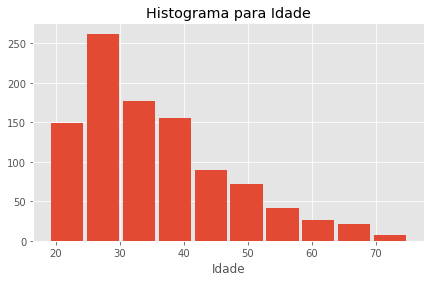

In [39]:
### Fazendo histograma (pode ser visto no Profile Report)
## Figura e Histograma
plt.figure(figsize=(7, 4))
plt.hist(data=df, x="Age", bins=20, rwidth=0.9)

## Título do gráfico e dos eixos
plt.xlabel("Idade")
plt.title("Histograma para Idade")
plt.show()

[Text(0, 0, 'Ruim'), Text(1, 0, 'Bom')]

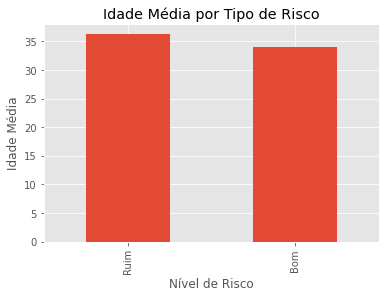

In [48]:
### Contando
## Objeto gráfico
ax = df.groupby("target")["Age"].mean().plot(kind="bar")

## Título
plt.title("Idade Média por Tipo de Risco")
plt.xlabel("Nível de Risco")
plt.ylabel("Idade Média")

## Ticks do eixo x
ax.set_xticklabels(["Ruim", "Bom"])

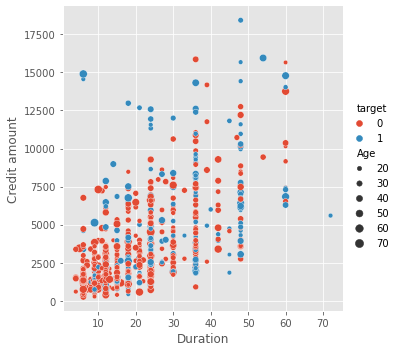

In [50]:
### Vendo a relação entre duração e crédito concedido, levando em conta o risco e a idade
## Gráfico
ax = sns.relplot(
    x="Duration", y="Credit amount",
    hue="target", size="Age",
    data=df
)

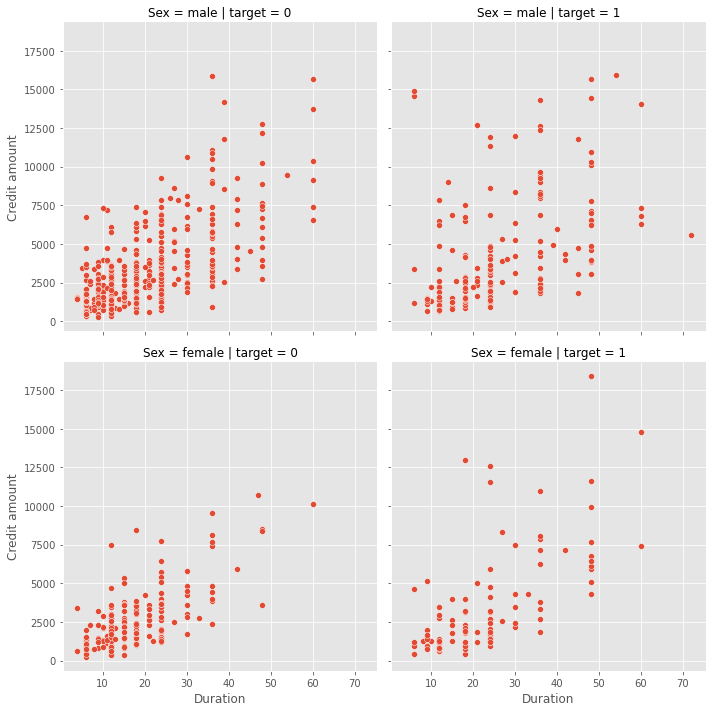

In [55]:
### Outra forma
ax = sns.relplot(
    x="Duration", y="Credit amount",
    col="target", row="Sex",
    data=df
)

## Também é possível mudar o marcador e o estilo da linha!
# Ver: https://seaborn.pydata.org/generated/seaborn.relplot.html

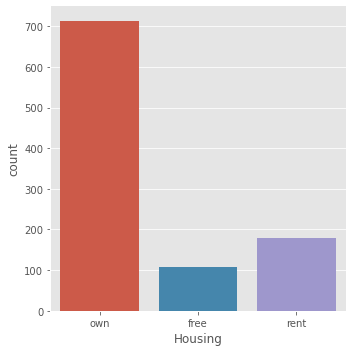

In [56]:
### Gráfico de contagem por categoria de casa
sns.catplot(x="Housing", kind="count", data=df)

<Figure size 3000x2400 with 0 Axes>

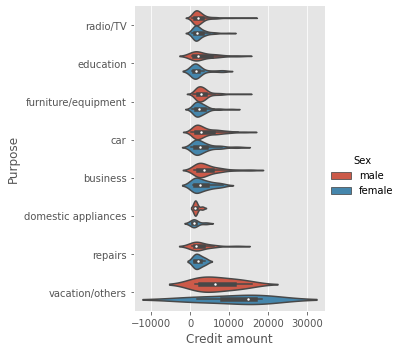

In [66]:
### Distribuição do valor por propósito do empréstimo e sexo
plt.figure(figsize=(10, 8), dpi=300)
sns.catplot(y="Purpose", x="Credit amount", hue="Sex", data=df,
            kind="violin", orient='h')

### Pandas-Profiling e Sweetviz

Facilita a sua vida! Se a análise for simples, usa um dashboard pré-pronto :)

#### Pandas-Profiling

In [67]:
## Gerando e visualizando o relatório
pfProfile = ProfileReport(df)
pfProfile.to_notebook_iframe()

## Gerando relatorio em html 
# pfProfile.to_file("Relatorio_Credito.html")

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


Coisas importantes:

- Alta correlação do valor do empréstimo com a duração (duh);
- 69% homens, 31% mulheres
- Maioria possui casa própria e pouca poupança;
- Poucos são os ricos de conta corrente;
- Maioria pede valores baixos de crédito;
- Maioria pede empréstimos para carro e para a compra de eletrodomésticos ou móveis;
- 70% tem bom risco (pagaram o empréstimo).

#### Sweetviz

In [68]:
## Gerando e visualizando o relatório
swReport = sv.analyze(df)
swReport.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Modelagem: Random Forest (RF)

### Primeiro: Árvores de Decisão

As árvores de decisão podem ser vistas como uma sequência de `ifs` e, por isso, conseguem captar bem não linearidades.

Cada cláusula `if` é um *fork* ou *node* na árvore, que dá origem a dois galhos (*branches*).
No limite, a árvore mais simples que existe olha para uma característica (por exemplo, o sexo) e fala: "bem, se é homem, vai ser mau pagador; se for mulher, vai pagar direitinho".

Contudo, há mulheres que dão calote (e nosso modelo geraria erros do **Tipo II**, ou seja, **falsos negativos**) e homens que pagam em dia (erro **Tipo I** ou **falsos positivos**).

<img src="./Imagens/ErrosTipo1Tipo2_Pregnant_Gravidez.jpeg" alt="Tipos de Erro" width="400"/>

Uma árvore de decisão funciona, portanto, com vários *ifs*, sendo que cada *fork* gera dois novos ramos e o processo segue por um número de etapas pré-definido. Note que *forks* subsequentes tomarão, na maioria das vezes, decisões com base em variáveis diferentes.


Para uma boa introdução sobre árvores de decisão, ver [esse site visual](http://www.r2d3.us/uma-introducao-visual-ao-aprendizado-de-maquina-1/).

### Random Forest

Como vimos acima, a Árvore de Decisão é um **algoritmo de classificação supervisionado**.

Contudo, uma árvore sozinha pode gerar erros, uma vez que a ordem dos galhos importa na classificação. E se fizessemos várias árvores; em outras palavras, e se plantarmos uma floresta?

Essencialmente, uma floresta aleatória cria várias árvores de decisão e compara as classificações de cada uma delas, sendo, portanto, um algoritmo de *emsemble learning* (combinação de vários algoritmos para aprender melhor).

Assim, podemos evitar que a árvore *overfit* os dados, ou seja, podemos aumentar a chance de generalização dos resultados para novos dados.

**Como funciona o RF?**

1. Coletamos uma amostra do dataset original, podendo haver repetições;
2. Começamos a construção de uma árvore de decisão a partir do dataset gerado pela amostragem acima. Cada árvore será criada apenas com um *subset* das variáveis/*features* (colunas) do dataset.
3. Seleciona-se uma variável para ser o 1º nó (*root node*); depois disso, essa variável não é usada nos nós seguintes;
4. Repete-se 3. até se exaurir o subconjunto de variáveis.
5. Repete-se o processo acima para se construir várias (centenas) árvores de decisão.

A classificação se dá por *majority voting*, ou seja, se 52% das árvores falam que uma observação será um mau pagador dada suas características, ele será classificado como tal. Se 49% dissessem que ele é mau pagador, ele não seria classificado dessa forma.

OBS: É preciso escolher o tamanho ideal para o subconjunto de *features* de cada árvore ($2, 3, n$...?)

#### Treino/Teste

In [69]:
## Listando as features que vamos usar
lFeatures = ["Age", "Job", "Credit amount", "Purpose", "Housing", "Duration"]

## Definindo a variável alvo
sTarget = "target"

In [70]:
## Divisão do dataset em features e rótulos (variável-alvo)
dfFeatures = df[lFeatures]
seriesLabels = df[sTarget]

In [74]:
## Dividindo em dados de teste e treino (30% de teste para o modelo)
X_train, X_test, y_train, y_test = train_test_split(
    dfFeatures, seriesLabels, test_size=0.3, random_state=999
)

#### Tratando (imputando) valores faltantes

Método: imputação (valor mais frequente)

Importante: sempre fazer APÓS a divisão de treino/teste!

In [ ]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
# adição das colunas com missing

#### Tratando (codificando) Variáveis Categóricas

Método: *one-hot encoding*.

Para fazer *encoding* de variáveis mais sujas (com nomes parecidos), ver *dirtycat*.

Importante: sempre fazer APÓS a divisão de treino/teste!

In [71]:
## Separando em features numéricas e catégoricas
lFeaturesCategoricas = ["Job", "Housing", "Purpose"]
lFeaturesNumericas = ["Age", "Credit amount", "Duration"]

In [75]:
## Codificando (gera um objeto de tipo especifíco)
encoder = ce.OneHotEncoder(cols=lFeaturesCategoricas)

## Transformando os dados de treino
X_train = encoder.fit_transform(X_train)

## Vendo resultado
X_train.head()

,Age,Job_1,Job_2,Job_3,Job_4,Credit amount,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Housing_1,Housing_2,Housing_3,Duration
763,30,1,0,0,0,12680,1,0,0,0,0,0,0,0,1,0,0,21
534,25,0,1,0,0,3105,0,1,0,0,0,0,0,0,0,1,0,24
86,27,0,1,0,0,1295,0,0,1,0,0,0,0,0,0,1,0,18
927,39,0,1,0,0,10297,1,0,0,0,0,0,0,0,1,0,0,48
134,21,0,1,0,0,10144,0,1,0,0,0,0,0,0,0,1,0,60


In [77]:
## Fazendo a mesma coisa com os dados de teste
X_test = encoder.transform(X_test)
X_test.head()

,Age,Job_1,Job_2,Job_3,Job_4,Credit amount,Purpose_1,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Housing_1,Housing_2,Housing_3,Duration
842,23,0,1,0,0,1943,0,0,0,0,1,0,0,0,0,1,0,18
68,37,0,1,0,0,1819,0,0,0,0,0,0,0,1,1,0,0,36
308,24,0,1,0,0,1237,0,0,1,0,0,0,0,0,0,1,0,8
881,48,0,1,0,0,9277,1,0,0,0,0,0,0,0,1,0,0,24
350,23,0,1,0,0,1236,0,0,0,0,0,0,1,0,0,0,1,9


#### Modelando RF!

In [78]:
## Instanciando o modelo de floresta aleatória classificadora
# Existe também o RandomForestRegression, usada para variáveis contínuas (usado, por exemplo, para renda)
clf_RF = RandomForestClassifier() 

In [79]:
## Treinando o modelo (criando várias árvores)
clf_RF.fit(X_train, y_train)

RandomForestClassifier()

In [80]:
## Aplicando no teste (1 = mau pagador)
y_pred = clf_RF.predict(X_test)

## Vendo array resultantes
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Avaliando

In [84]:
## Acurácia (% de acerto)
# Cuidado: com dados desbalanceados, pode gerar interpretações erradas
# Ex: se 98% fosse mau pagador e o modelo classificasse geral como caloteiro (acurácia de 98%, mas modelo ruim)
print(f"Acurácia: {round(accuracy_score(y_test, y_pred), 4)}")

## F1 Score (quanto mais próximo de 1, melhor)
print(f"F1 Score: {round(f1_score(y_test, y_pred), 4)}")

Acurácia: 0.6467
F1 Score: 0.274


Como temos poucas *features* e o dataset é relativamente pequeno, o modelo não performa tão bem.

In [85]:
## Matriz de confusão: tipos de erros
# .ravel: pega uma matriz e transforma em array unidimensional
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positive: " + str(tp))
print("True Negative: " + str(tn))
print("False Positive: " + str(fp))
print("False Negative: " + str(fn))

# Lembrando: falso negativo = vocé não está grávida (tipo 2); falso positivo = voce está grávidO (tipo 1)

True Positive: 20
True Negative: 174
False Positive: 25
False Negative: 81


In [88]:
## Vendo a importância de cada feature no modelo
# Criando série
seriesFeatureImportance = pd.Series(
    clf_RF.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

Text(0.5, 1.0, 'Features mais Importantes')

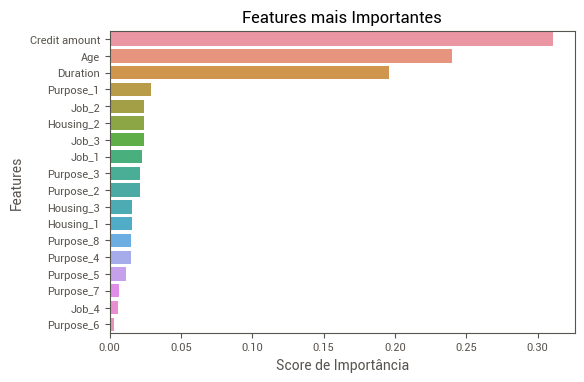

In [89]:
## Criando gráfico de barras
# Objeto do seaborn
sns.barplot(x=seriesFeatureImportance, y=seriesFeatureImportance.index)

# Títulos
plt.xlabel("Score de Importância")
plt.ylabel("Features")
plt.title("Features mais Importantes")

In [94]:
# Tunando os hiperparâmetros:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    "n_estimators": randint(4, 200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    "max_features": truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    "min_samples_split": uniform(0.01, 0.199),
}

# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 10 models over 5 folds of cross validation (50 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=10, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

In [95]:
# Qual combinação de parâmetros trouxe melhor resultado:
model.best_estimator_

RandomForestClassifier(max_features=0.2846112054232423,
                       min_samples_split=0.08719423749123947, n_estimators=138)

In [96]:
clf_random = RandomForestClassifier(max_features=0.2846112054232423,
                       min_samples_split=0.08719423749123947, n_estimators=138)

clf_random.fit(X_train, y_train)

RandomForestClassifier(max_features=0.2846112054232423,
                       min_samples_split=0.08719423749123947, n_estimators=138)

In [97]:
y_pred_random = clf_random.predict(X_test)

print("Acurácia: " + str(accuracy_score(y_test, y_pred_random)))

print("F1 Score: {}".format(f1_score(y_test, y_pred_random)))

# Melhorou acurácia, mas piorou f-score
# SearchCV causa overfitting!

Acurácia: 0.6766666666666666
F1 Score: 0.17094017094017094
